# データシステムの知能化とデザイン
# 第9回課題
## 学籍番号：62116674
## 氏名：藤本巧実

## 課題(CVAE)

ライブラリのインポートと定義

In [1]:
cuda = "cuda:0"
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
# ハイパーパラメータ集
SEED = 0
CLASS_SIZE = 10
BATCH_SIZE = 256
ZDIM = 16
NUM_EPOCHS = 50
# GPU存在のチェック
DEVICE = torch.device(cuda if torch.cuda.is_available() else "cpu")
print(DEVICE)
# シードの設定
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
# データセットとデータローダの準備
train_dataset = torchvision.datasets.MNIST(
  root='mydata', train=True, transform=transforms.ToTensor(), download=True,
)
train_loader = torch.utils.data.DataLoader(
  dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True,num_workers=0
)

cuda:0


100%|██████████| 9912422/9912422 [00:00<00:00, 113375213.71it/s]


Extracting mydata/MNIST/raw/train-images-idx3-ubyte.gz to mydata/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 107199729.05it/s]


Extracting mydata/MNIST/raw/train-labels-idx1-ubyte.gz to mydata/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 34616150.10it/s]


Extracting mydata/MNIST/raw/t10k-images-idx3-ubyte.gz to mydata/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 22049223.11it/s]

Extracting mydata/MNIST/raw/t10k-labels-idx1-ubyte.gz to mydata/MNIST/raw



### CVAEのモデルの定義と処理記述

In [2]:
class CVAE(nn.Module):
  def __init__(self, zdim):
    super().__init__()
    self._zdim = zdim
    self._in_units = 28 * 28
    hidden_units = 512
    self._encoder = nn.Sequential(
      nn.Linear(self._in_units + CLASS_SIZE, hidden_units),
      nn.ReLU(inplace=True),
      nn.Linear(hidden_units, hidden_units),
      nn.ReLU(inplace=True),
    )
    self._to_mean = nn.Linear(hidden_units, zdim)
    self._to_lnvar = nn.Linear(hidden_units, zdim)
    self._decoder = nn.Sequential(
      nn.Linear(zdim + CLASS_SIZE, hidden_units),
      nn.ReLU(inplace=True),
      nn.Linear(hidden_units, hidden_units),
      nn.ReLU(inplace=True),
      nn.Linear(hidden_units, self._in_units),
      nn.Sigmoid()
    )
  def encode(self, x, labels):
    in_ = torch.empty((x.shape[0], self._in_units + CLASS_SIZE), device=DEVICE)
    in_[:, :self._in_units] = x
    in_[:, self._in_units:] = labels
    h = self._encoder(in_)
    mean = self._to_mean(h)
    lnvar = self._to_lnvar(h)
    return mean, lnvar
  def decode(self, z, labels):
    in_ = torch.empty((z.shape[0], self._zdim + CLASS_SIZE), device=DEVICE)
    in_[:, :self._zdim] = z
    in_[:, self._zdim:] = labels
    return self._decoder(in_)

In [3]:
def to_onehot(label):
  return torch.eye(CLASS_SIZE, device=DEVICE, dtype=torch.float32)[label]
model = CVAE(ZDIM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [4]:
model.train()
for e in range(NUM_EPOCHS):
  train_loss = 0
  for i, (images, labels) in enumerate(train_loader):
    labels = to_onehot(labels)
    x = images.view(-1, 28*28*1).to(DEVICE) # 画像を1次元へ
    mean, lnvar = model.encode(x, labels) # ラベルと一緒にエンコーダへ
    std = lnvar.exp().sqrt()
    epsilon = torch.randn(ZDIM, device=DEVICE) # 乱数を生成
    z = mean + std * epsilon # 潜在変数を変換
    y = model.decode(z, labels) # デコード
    # ロスを計算
    kld = 0.5 * (1 + lnvar - mean.pow(2) - lnvar.exp()).sum(axis=1)
    bce = F.binary_cross_entropy(y, x, reduction='none').sum(axis=1)
    loss = (-1 * kld + bce).mean()
    # Update model
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss += loss.item() * x.shape[0]
  print(f'epoch: {e + 1} epoch_loss: {train_loss/len(train_dataset)}')

epoch: 1 epoch_loss: 200.65672473958332
epoch: 2 epoch_loss: 162.0748071533203
epoch: 3 epoch_loss: 149.62745239257814
epoch: 4 epoch_loss: 140.633934765625
epoch: 5 epoch_loss: 134.43958129882813
epoch: 6 epoch_loss: 128.65976556396484
epoch: 7 epoch_loss: 124.79452200520834
epoch: 8 epoch_loss: 121.53033059895833
epoch: 9 epoch_loss: 119.03040912272135
epoch: 10 epoch_loss: 116.74512845458985
epoch: 11 epoch_loss: 115.56128503011068
epoch: 12 epoch_loss: 113.10184892578125
epoch: 13 epoch_loss: 111.83694932454426
epoch: 14 epoch_loss: 110.68304062906901
epoch: 15 epoch_loss: 109.70443263346354
epoch: 16 epoch_loss: 109.24656520589193
epoch: 17 epoch_loss: 108.64263603922527
epoch: 18 epoch_loss: 106.90806599121093
epoch: 19 epoch_loss: 107.07688297932943
epoch: 20 epoch_loss: 106.06920703938802
epoch: 21 epoch_loss: 105.77486899414062
epoch: 22 epoch_loss: 105.13951073404948
epoch: 23 epoch_loss: 104.70742505696614
epoch: 24 epoch_loss: 104.88402884114583
epoch: 25 epoch_loss: 103.67

正解ラベルの学習

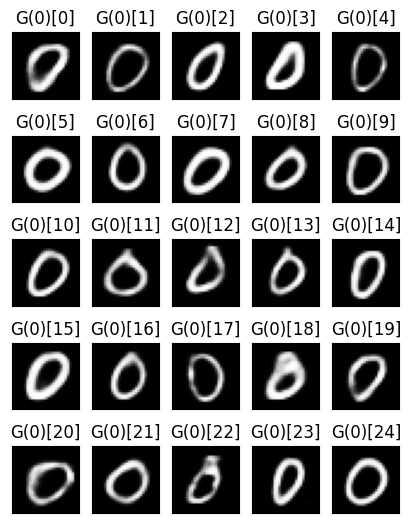

In [5]:
getlabel = 0
NUM_GENERATION = 25
model.eval()
allz = []
fig, ax = plt.subplots(5, 5, figsize=(5,6.5))
for i in range(NUM_GENERATION):
  z = torch.randn(ZDIM, device=DEVICE).unsqueeze(dim=0)
  label = torch.tensor([getlabel], device=DEVICE)
  with torch.no_grad():
    y = model.decode(z, to_onehot(label))
  y = y.reshape(28, 28).cpu().detach().numpy()
  # Save image
  ly = int(i/5)
  lx = i%5
  ax[ly, lx].imshow(y, cmap='gray')
  ax[ly, lx].set_title(f'G({label.cpu().detach().numpy()[0]})[{i}]')
  ax[ly, lx].tick_params(
    labelbottom=False,
    labelleft=False,
    bottom=False,
    left=False,
  )
  allz.append(z)
plt.show()

`genseries`関数を定義

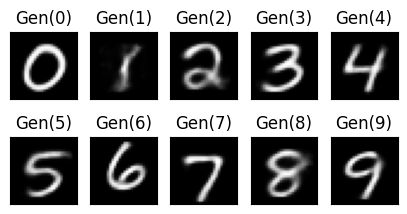

In [6]:
def genseries(z):
  model.eval()
  fig, ax = plt.subplots(2, 5, figsize=(5,2.5))
  for label in range(CLASS_SIZE):
    with torch.no_grad():
      y = model.decode(z, to_onehot(label))
    y = y.reshape(28, 28).cpu().detach().numpy()
    # Save image
    ly = int(label/5)
    lx = label%5
    ax[ly, lx].imshow(y, cmap='gray')
    ax[ly, lx].set_title(f'Gen({label})')
    ax[ly, lx].tick_params(
      labelbottom=False,
      labelleft=False,
      bottom=False,
      left=False,
    )
  plt.show()
genseries(z)

手書き文字画像のダウンロード

In [14]:
if not os.path.exists('DataAI_AE_test_5.jpg'):
  #!wget "https://drive.google.com/uc?export=download&id=1o1xxp0AtkCyjTTLW_oyqSKVHX5lLAJuN" -O mytest.jpg
  !wget https://keio.box.com/shared/static/n2sdt9rvju9b6tcsuer9wogy8770c5is -O mytest.jpg

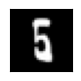

In [15]:
from PIL import Image
from PIL import ImageOps
my_label = 5
from scipy.ndimage import center_of_mass
my_fig = Image.open("DataAI_AE_test_5.jpg")
my_img = ImageOps.invert(my_fig.resize((28, 28)).convert("L"))
plt.figure(figsize=(0.8, 0.8))
plt.tick_params(
  labelbottom=False,
  labelleft=False,
  bottom=False,
 left=False,
)
plt.imshow(my_img, cmap='gray')

手書き文字をもとに，他の数字を作成

In [17]:
my_input = torch.tensor(np.array(my_img)/256)
x = my_input.view(1, 28*28).to(DEVICE)
label = torch.tensor(np.array(my_label)).clone().to(DEVICE)
with torch.no_grad():
  mean, _ = model.encode(x, to_onehot(label))
z = mean
print(f'z = {z}')

z = tensor([[-0.0943, -1.8385, -1.9110, -0.9236, -1.4633, -1.4984, -0.0912, -0.1708,
         -0.0430,  0.0152, -0.2413, -0.0198, -0.1940,  1.9656, -0.8759,  0.0106]],
       device='cuda:0')


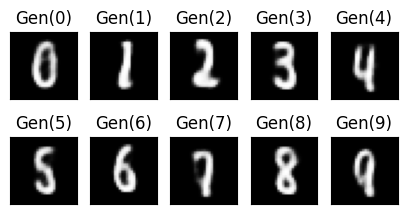

In [18]:
genseries(z)